In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import os
from torch.utils.data import DataLoader

In [ ]:
NUMBER_NODES = 10
# NUMBER_NODES = 5

In [ ]:
def load_data():
    # not being used, but works as another approach to load the data
    def get_split_tensor_dataset(df, numberDigits):
        # df.iloc[row_start (0 default) : row_end (last default) , col_start (0 default) : col_end (last default)]
        X_df = df.iloc[ : , 0: numberDigits]
        Y_df = df.iloc[ : , numberDigits + 1 : ] # skip bandwidth value, and get the remaining labels
        X = X_df.to_numpy()
        Y = Y_df.to_numpy()
        return torch.from_numpy(X), torch.from_numpy(Y)

    numberDigits = (NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2
    if numberDigits == 45: # o de 10 nao ta otimizado AJEITAR
      numberDigits = 100

    def get_tuple_tensor_dataset(row):
        X = row[0 : numberDigits].astype('float32')
        # Y = row[numberDigits + 1 : ].astype('float32') # o de 10 nao ta otimizado AJEITAR
        Y = row[numberDigits : ].astype('float32')
        return (torch.from_numpy(X), torch.from_numpy(Y))
        

    df = pd.read_csv(f'./opt_band_{NUMBER_NODES}_nodes_graph.csv')
    df = df.sample(frac=1).reset_index(drop=True) # shuffle
    train_dataset_df = df.sample(frac=0.7)
    df_remaining = df.drop(index=train_dataset_df.index)
    val_dataset_df = df_remaining.sample(frac=0.7)
    test_dataset_df = df_remaining.drop(index=val_dataset_df.index)

    train_dataset = list(map(get_tuple_tensor_dataset, train_dataset_df.to_numpy()))
    val_dataset = list(map(get_tuple_tensor_dataset, val_dataset_df.to_numpy()))
    test_dataset = list(map(get_tuple_tensor_dataset, test_dataset_df.to_numpy()))
    return train_dataset, val_dataset, test_dataset

    # X_train, Y_train = get_split_tensor_dataset(train_dataset_df, numberDigits)
    # X_val, Y_val = get_split_tensor_dataset(val_dataset_df, numberDigits)
    # X_test, Y_test = get_split_tensor_dataset(test_dataset_df, numberDigits)
    # return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [ ]:
training_data, val_data, test_data = load_data()

train_dataloader = DataLoader(training_data, batch_size=10, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=10, shuffle=True)

In [ ]:
for x, y in train_dataloader:
    print("Shape of X [Batches, Digits in each Batch]: ", x.shape)
    print("Grad = ", x.requires_grad)
    print("Shape of y [Batches, Optimal labels in each Batch]: ", y.shape)
    break

Shape of X [Batches, Digits in each Batch]:  torch.Size([10, 100])
Grad =  False
Shape of y [Batches, Optimal labels in each Batch]:  torch.Size([10, 10])


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(100, 200)
        # self.fc1 = nn.Linear((NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2 , 200) AJEITAR
        self.fc2 = nn.Linear(200, NUMBER_NODES)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CustomLoss(nn.Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self,output,target):
        #return ((output-target)**2).mean() + (output % 1).sum(dim=1).mean()
        return ((output-target)**2).mean()
        #return ((output-target)**2).sum(dim=1).mean()

In [ ]:
# train v2 https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

def train(dataloader, model, loss_fn, optimizer, list_train_loss, list_train_loss_not_sum, goal, epoch):
    # model.train() # turn on possible layers/parts specific for training, like Dropouts for example
    train_loss = 0
    printed = 0 # AJEITAR
    loss = None
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # print statistics
        if not printed and epoch % 100 == 0:
            print(f'Epoch {epoch + 1} Loss: {loss.item()}')
            printed = 1

        # goal
        if loss.item() <= goal:
            print('The goal of learning is reached')
            print(f'{epoch + 1} Loss: {loss.item()}')
            break
            test_loss /= num_batches
    list_train_loss.append(train_loss / len(dataloader))
    list_train_loss_not_sum.append(loss.item())

def validate(dataloader, model, loss_fn, list_val_loss, list_val_loss_not_sum):
    # model.eval() # turn off possible layers/parts specific for training, like Dropouts for example
    eval_loss = 0
    # with torch.no_grad(): # turn off gradients computation
    loss = None
    for x, y in dataloader:
        pred = model(x)
        loss = loss_fn(pred, y)
        eval_loss += loss.item()
    list_val_loss.append(eval_loss / len(dataloader))
    list_val_loss_not_sum.append(loss.item())
    

def test(dataloader, model, loss_fn, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad(): # turn off gradients computation
        for X, y in dataloader:
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            correct += torch.all(y.eq(pred.round())).item()
    test_loss /= num_batches
    correct /= size
    if epoch % 200 == 0:
      print(f"Test Error:\nAccuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 600

model = NeuralNetwork()

loss_fn = CustomLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

list_train_loss = list()
list_val_loss = list()

list_train_loss_not_sum = list()
list_val_loss_not_sum = list()

goal = 0.5e-3

for epoch in range(epochs):
    if epoch % 100 == 0:
      print(f"Epoch {epoch + 1}...")
    # for each epoch, we got a loss training and a loss validating.
    train(train_dataloader, model, loss_fn, optimizer, list_train_loss, list_train_loss_not_sum, goal, epoch)
    validate(val_dataloader, model, loss_fn, list_val_loss, list_val_loss_not_sum)
    test(test_dataloader, model, loss_fn, epoch)
    if list_train_loss[-1] <= goal:
            break


Epoch 1...
Epoch 1 Loss: 28.538679122924805
Test Error:
Accuracy: 0.0%, Avg loss: 7.680594 

Epoch 101...
Epoch 101 Loss: 6.929299354553223
Epoch 201...
Epoch 201 Loss: 7.364140033721924
Test Error:
Accuracy: 0.0%, Avg loss: 5.508087 

Epoch 301...
Epoch 301 Loss: 5.123535633087158
Epoch 401...
Epoch 401 Loss: 6.515468597412109
Test Error:
Accuracy: 0.0%, Avg loss: 5.385015 

Epoch 501...
Epoch 501 Loss: 4.711188316345215


600
600
Loss val array:
[7.640552121188801, 7.469188797615263, 7.307222181629286, 7.1533407071833555, 7.007306928220003, 6.858066215816693, 6.7566813272921, 6.682878151241498, 6.598518824860041, 6.5521749356989805, 6.504768880459631, 6.477631233426422, 6.4118870868984414, 6.383224933986136, 6.33606509540392, 6.296565282486173, 6.276958990473992, 6.270520869922261, 6.229792258485032, 6.205768956497253, 6.185362533147156, 6.165955132646523, 6.143643723174988, 6.1172335185552305, 6.1115189559846055, 6.089601507299974, 6.082883063041175, 6.075135755915887, 6.031945548981075, 6.0344803135385625, 6.034398715015457, 5.996513644697167, 5.994987625378394, 5.9872870011763135, 5.965010971891079, 5.951582733350309, 5.970629009804707, 5.941547144071858, 5.940356045372401, 5.920735027479089, 5.911560010533088, 5.896724585016726, 5.914214647805738, 5.8727119496688545, 5.8797465953902295, 5.865611180957599, 5.861172623313934, 5.854509904921762, 5.865769190279392, 5.847124060152076, 5.841819920558703, 

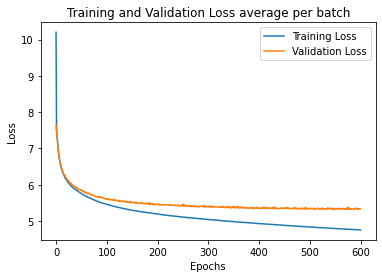

In [ ]:
print(len(list_train_loss))
print(len(list_val_loss))
print("Loss val array:")
print(list_val_loss)
print("Loss val first:")
print(list_val_loss[0])
print("Loss val last:")
print(list_val_loss[-1])

plt.plot(list_train_loss, label='Training Loss')
plt.plot(list_val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss average per batch')
plt.show()

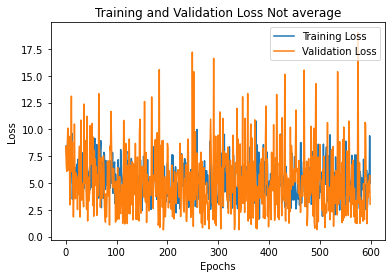

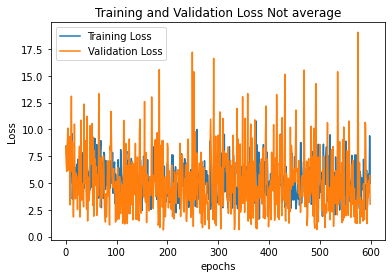

In [ ]:
plt.plot(list_train_loss_not_sum, label='Training Loss')
plt.plot(list_val_loss_not_sum, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss Not average')
plt.show()

In [ ]:
print(test_data[0])
print(type(test_data[0]))

for i in range(3):
  pred = model(test_data[i][0])
  print(pred.round())
  print(test_data[i][1])
  print("\n\n")

(tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1.,
        1., 0., 1., 1., 1., 0., 0., 1., 1., 0.]), tensor([6., 7., 1., 2., 0., 9., 8., 4., 5., 3.]))
<class 'tuple'>
tensor([4., 4., 3., 5., 5., 7., 6., 3., 4., 4.], grad_fn=<RoundBackward>)
tensor([6., 7., 1., 2., 0., 9., 8., 4., 5., 3.])



tensor([4., 4., 3., 5., 5., 8., 5., 3., 3., 4.], grad_fn=<RoundBackward>)
tensor([4., 9., 2., 3., 7., 0., 1., 8., 6., 5.])



tensor([5., 5., 4., 4., 4., 4., 6., 5., 4., 4.], grad_fn=<RoundBackward>)
tensor([8., 2., 7., 5., 1., 0., 9., 6., 3., 4.])





In [ ]:
def load_data_v1():
    numberDigits = 100 # o de 10 nao ta otimizado AJEITAR

    def get_split_tensor_dataset(df, numberDigits):
        # df.iloc[row_start (0 default) : row_end (last default) , col_start (0 default) : col_end (last default)]
        X_df = df.iloc[ : , 0: numberDigits]
        # Y_df = df.iloc[ : , numberDigits + 1 : ] # skip bandwidth value, and get the remaining labels
        Y_df = df.iloc[ : , numberDigits : ] # o de 10 nao ta otimizado AJEITAR
        X = X_df.to_numpy().astype('float32')
        Y = Y_df.to_numpy().astype('float32')
        return torch.from_numpy(X), torch.from_numpy(Y)

    df = pd.read_csv(f'./opt_band_{NUMBER_NODES}_nodes_graph.csv')
    df = df.sample(frac=1).reset_index(drop=True) # shuffle
    train_dataset_df = df.sample(frac=0.7)
    df_remaining = df.drop(index=train_dataset_df.index)
    val_dataset_df = df_remaining.sample(frac=0.7)
    test_dataset_df = df_remaining.drop(index=val_dataset_df.index)

    X_train, Y_train = get_split_tensor_dataset(train_dataset_df, numberDigits)
    X_val, Y_val = get_split_tensor_dataset(val_dataset_df, numberDigits)
    X_test, Y_test = get_split_tensor_dataset(test_dataset_df, numberDigits)
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [ ]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = load_data_v1()
print(X_train.shape)
print(X_val.shape)
print(Y_val.shape)

torch.Size([8407, 100])
torch.Size([2522, 100])
torch.Size([2522, 10])


In [ ]:
# train v1

model_v1 = NeuralNetwork()

loss_fn = CustomLoss()
optimizer = optim.SGD(model_v1.parameters(), lr=0.001)

epochs = 600
goal = 0.5e-3
show = 250
batch_size = 30
train_size = len(X_train)
batchs = train_size // batch_size

list_train_loss_v1 = list()
list_val_loss_v1 = list()
        
print('\nTrainning')
for epoch in range(epochs):
    start = 0
    end = batch_size
    
    printed = 0

    loss = None
    loss = None
    for batch in range(batchs):
        x = X_train[start : end]
        y = Y_train[start : end]

        pred = model_v1(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        start += batch_size
        end += batch_size

        # print statistics
        if not printed and epoch % 200 == 0:
            print(f'Epoch {epoch + 1} Loss: {loss.item()}')
            printed = 1

        # goal
        if loss.item() <= goal:
            print('The goal of learning is reached')
            print(f'{epoch + 1} Loss: {loss.item()}')
            break
            
    list_train_loss_v1.append(loss.item())
    pred = model_v1(X_val)
    val_loss = loss_fn(pred, Y_val)
    list_val_loss_v1.append(val_loss.item())
        
print('Finished Training')


Trainning
Epoch 1 Loss: 27.99010467529297
Epoch 201 Loss: 6.171494483947754
Epoch 401 Loss: 6.06926155090332
Finished Training


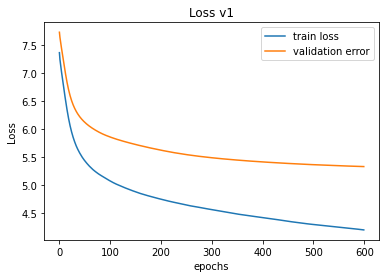

In [ ]:
x = list(range(len(list_train_loss_v1)))

# consolidate
fig, ax = plt.subplots()
ax.plot(x, list_train_loss_v1, label='train loss')
ax.plot(x, list_val_loss_v1, label='validation error')
ax.set(xlabel='epochs', ylabel='Loss', title='Loss v1')

plt.legend()
#plt.savefig('loss.png')
plt.show()

In [ ]:
print(X_test[0])
print(type(X_test[0]))

for i in range(3):
  pred = model_v1(X_test[i])
  print(pred.round())
  print(Y_test[i])
  print("\n\n")

tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
        1., 1., 1., 0., 0., 1., 1., 0., 0., 0.])
<class 'torch.Tensor'>
tensor([4., 5., 4., 4., 5., 5., 4., 4., 4., 5.], grad_fn=<RoundBackward>)
tensor([4., 3., 5., 9., 8., 0., 1., 6., 7., 2.])



tensor([4., 5., 3., 4., 3., 8., 4., 4., 3., 4.], grad_fn=<RoundBackward>)
tensor([2., 8., 7., 1., 6., 9., 0., 4., 5., 3.])



tensor([5., 5., 0., 6., 7., 8., 6., 5., 2., 2.], grad_fn=<RoundBackward>)
tensor([4., 3., 0., 8., 9., 7., 6., 5., 1., 2.])



